In [60]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.metaestimators import _BaseComposition
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.all_model import AllModel, AllModelData
from server.ml_models.sklearn import AveragingRegressor
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance

np.random.seed(42)

n_iter = 5


class StackingRegressor(_BaseComposition, RegressorMixin):
    def __init__(self, estimators, meta_estimator):
        self.estimators = estimators
        self.meta_estimator = meta_estimator

    def fit(self, X, y):
        predictions = {}

        for idx, (_, estimator) in enumerate(self.estimators):
            estimator.fit(X, y)
            predictions[idx] = estimator.predict(X)

        X_all = pd.DataFrame(predictions)
        self.meta_estimator.fit(X_all, y)
            
        return self
            
    def predict(self, X):
        predictions = {str(idx): estimator.predict(X) for idx, (_, estimator) in enumerate(self.estimators)}

        X_all = pd.DataFrame(predictions)

        return self.meta_estimator.predict(X_all)
    
    # The params Dict is way too complicated to try typing it
    def get_params(self, deep=True):
        return super()._get_params("estimators", deep=deep)

    def set_params(self, **params):
        super()._set_params("estimators", **params)

        return self

## Compare averaging, stacking, and bagging

In [62]:
# Take top-performing models from all data notebook (6.2-all-data-nn)

ESTIMATORS = [
    ('ridge', Ridge),
    ('gradientboostingregressor', GradientBoostingRegressor),
    ('linearsvr', LinearSVR),
    ('xgbregressor', XGBRegressor),
]

models = []
data = AllModelData(train_years=(None, 2015), test_years=(2016, 2016))
features, labels = data.train_data()
X_train, X_test, y_train, y_test = train_test_split(features, labels)

for name, estimator in ESTIMATORS:
    model = AllModel(pipeline=make_pipeline(StandardScaler(), estimator()), name=name)
    models.append((name, model))

all_model = AllModel()
bag_model = BaggingRegressor(base_estimator=AllModel())
avg_model = AveragingRegressor(models)
stack_model = StackingRegressor(models, make_pipeline(StandardScaler(), XGBRegressor()))

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


### All data with XGB

In [27]:
n_iter = 5

all_params = {
    'pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

all_cv = RandomizedSearchCV(all_model, all_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, n_iter=n_iter)

In [28]:
all_cv.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=AllModel(name='AllModel',
     pipeline=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, m...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__xgbregressor__colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4d4abc4b70>, 'pipeline__xgbregressor__colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4d426464e0>},
          

In [29]:
all_cv.best_score_, all_cv.best_params_

(-26.639591417298575,
 {'pipeline__xgbregressor__booster': 'dart',
  'pipeline__xgbregressor__colsample_bylevel': 0.9491853641362369,
  'pipeline__xgbregressor__colsample_bytree': 0.8147312877395928,
  'pipeline__xgbregressor__learning_rate': 0.10448826482204984,
  'pipeline__xgbregressor__max_depth': 4,
  'pipeline__xgbregressor__n_estimators': 94,
  'pipeline__xgbregressor__reg_alpha': 0.11313172406665915,
  'pipeline__xgbregressor__reg_lambda': 0.7558974366822621,
  'pipeline__xgbregressor__subsample': 0.8422239778965759})

### Bagging with XGB

In [79]:
bag_params = {
    'n_estimators': stats.randint(5, 15),
    'base_estimator__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'base_estimator__pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'base_estimator__pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'base_estimator__pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'base_estimator__pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'base_estimator__pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'base_estimator__pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'base_estimator__pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'base_estimator__pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

bag_cv = RandomizedSearchCV(bag_model, bag_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, n_iter=n_iter)

In [80]:
bag_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BaggingRegressor(base_estimator=AllModel(name='AllModel',
     pipeline=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytr...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b74ef15c0>, 'base_estimator__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'], 'base_estimator__pipeline__xgbregressor__colsample_bylevel': <scipy.stats._distn_infrastructure.rv_frozen ob...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b74ef1dd8>},
          pre_dispatch='2*n_jobs', random_state=None

In [81]:
bag_cv.best_score_, bag_cv.best_params_

(-26.548679351174687,
 {'base_estimator__pipeline__xgbregressor__booster': 'dart',
  'base_estimator__pipeline__xgbregressor__colsample_bylevel': 0.932410481813671,
  'base_estimator__pipeline__xgbregressor__colsample_bytree': 0.8477673728891532,
  'base_estimator__pipeline__xgbregressor__learning_rate': 0.12003700927898357,
  'base_estimator__pipeline__xgbregressor__max_depth': 4,
  'base_estimator__pipeline__xgbregressor__n_estimators': 90,
  'base_estimator__pipeline__xgbregressor__reg_alpha': 0.025859007817833925,
  'base_estimator__pipeline__xgbregressor__reg_lambda': 0.9186496206570707,
  'base_estimator__pipeline__xgbregressor__subsample': 0.9130436248456849,
  'n_estimators': 10})

### Stacked with XGB

In [64]:
stack_params = {
    'ridge__pipeline__ridge__alpha': stats.uniform(0.75, 0.5),
    'ridge__pipeline__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': stats.uniform(0.7, 0.3),
    'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': stats.uniform(0.075, 0.05),
    'gradientboostingregressor__pipeline__gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': stats.randint(2, 10),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': stats.uniform(0.8, 0.2),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': [None, 2, 4, 6, 8, 10],
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': stats.randint(1, 5),
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': stats.randint(2, 6),
    'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': stats.randint(75, 150),
    'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': stats.uniform(0.8, 0.2),
    'linearsvr__pipeline__linearsvr__C': stats.uniform(0.75, 0.5),
    'linearsvr__pipeline__linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'xgbregressor__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'xgbregressor__pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'xgbregressor__pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'xgbregressor__pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'xgbregressor__pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'xgbregressor__pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'xgbregressor__pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

stack_cv = RandomizedSearchCV(stack_model, stack_params, scoring='neg_mean_absolute_error', n_jobs=-1,
                              cv=5, n_iter=n_iter)

In [65]:
stack_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=StackingRegressor(estimators=[('ridge', AllModel(name='ridge',
     pipeline=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'ridge__pipeline__ridge__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b6bf5edd8>, 'ridge__pipeline__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': <s...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b74816c50>},
          pre_dispatch='2*n_jobs', random_state=None

In [66]:
stack_cv.best_score_, stack_cv.best_params_

(-26.854241350190442,
 {'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': 0.9863384977407668,
  'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': 0.09048008240664918,
  'gradientboostingregressor__pipeline__gradientboostingregressor__loss': 'lad',
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': 4,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': 0.8972541821696156,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': 4,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': 1,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': 3,
  'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': 134,
  'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': 0.9476850202485767,
  'linearsvr__pipeline__linearsvr__C': 1.2241922131363083,
  '

### Averaging estimates

In [75]:
avg_params = {
    'weights': [stats.uniform(0.0, 1.0).rvs(size=4) for _ in range(n_iter)],
    'ridge__pipeline__ridge__alpha': stats.uniform(0.75, 0.5),
    'ridge__pipeline__ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': stats.uniform(0.7, 0.3),
    'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': stats.uniform(0.075, 0.05),
    'gradientboostingregressor__pipeline__gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': stats.randint(2, 10),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': stats.uniform(0.8, 0.2),
    'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': [None, 2, 4, 6, 8, 10],
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': stats.randint(1, 5),
    'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': stats.randint(2, 6),
    'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': stats.randint(75, 150),
    'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': stats.uniform(0.8, 0.2),
    'linearsvr__pipeline__linearsvr__C': stats.uniform(0.75, 0.5),
    'linearsvr__pipeline__linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'xgbregressor__pipeline__xgbregressor__booster': ['gbtree', 'gblinear', 'dart'],
    'xgbregressor__pipeline__xgbregressor__colsample_bylevel': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__colsample_bytree': stats.uniform(0.8, 0.2),
    'xgbregressor__pipeline__xgbregressor__learning_rate': stats.uniform(0.075, 0.05),
    'xgbregressor__pipeline__xgbregressor__max_depth': stats.randint(2, 10),
    'xgbregressor__pipeline__xgbregressor__n_estimators': stats.randint(75, 150),
    'xgbregressor__pipeline__xgbregressor__reg_alpha': stats.uniform(0.0, 0.2),
    'xgbregressor__pipeline__xgbregressor__reg_lambda': stats.uniform(0.75, 0.5),
    'xgbregressor__pipeline__xgbregressor__subsample': stats.uniform(0.8, 0.2),
}

avg_cv = RandomizedSearchCV(avg_model, avg_params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, n_iter=n_iter)

In [76]:
avg_cv.fit(*data.train_data())

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=AveragingRegressor(estimators=[('ridge', AllModel(name='ridge',
     pipeline=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', ...    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])))],
          weights=None),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'weights': [array([0.09533, 0.11515, 0.77891, 0.1713 ]), array([0.86772, 0.44668, 0.74245, 0.24462]), array([0.95566, 0.18025, 0.04762, 0.75589]), array([0.94426, 0.02118, 0.64632, 0.38503]), array([0.61832, 0.36988, 0.3187 , 0.95104])], 'ridge__pipeline__ridge__alpha': <scipy.s...e__xgbregressor__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b77168898>}

In [77]:
avg_cv.best_score_, avg_cv.best_params_

(-26.557213833059446,
 {'gradientboostingregressor__pipeline__gradientboostingregressor__alpha': 0.9963368961519148,
  'gradientboostingregressor__pipeline__gradientboostingregressor__learning_rate': 0.10589004751349954,
  'gradientboostingregressor__pipeline__gradientboostingregressor__loss': 'ls',
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_depth': 8,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_features': 0.8005999403651939,
  'gradientboostingregressor__pipeline__gradientboostingregressor__max_leaf_nodes': 10,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_leaf': 3,
  'gradientboostingregressor__pipeline__gradientboostingregressor__min_samples_split': 3,
  'gradientboostingregressor__pipeline__gradientboostingregressor__n_estimators': 100,
  'gradientboostingregressor__pipeline__gradientboostingregressor__subsample': 0.8621556031199317,
  'linearsvr__pipeline__linearsvr__C': 0.8104159010209905,
  '

In [82]:
bag_cv.score(*data.test_data()), avg_cv.score(*data.test_data())

(-28.119399610209474, -28.654095252250897)

### Bagging XGB is a little better than averaging a few different models
I played around with more or less estimators passed to the averaging regressor, but bagging had a better error than all combinations.

In [140]:
avg_model.set_params(**avg_cv.best_params_)
bag_model.set_params(**bag_cv.best_params_)
data.train_years = (None, 2016)
features, labels = data.train_data()

YEAR_ESTIMATORS = [
    ('average', avg_model, {}),
    ('bag', bag_model, {})
]

year_scores = yearly_performance_scores(YEAR_ESTIMATORS, features, labels)
year_scores

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,accuracy,error,model,year
0,0.770408,29.085249,average,2011
1,0.750000,29.897104,bag,2011
2,0.763285,27.708132,average,2012
3,0.768116,27.757896,bag,2012
4,0.746377,27.296080,average,2013
5,0.743961,26.938662,bag,2013
6,0.731884,29.181485,average,2014
7,0.731884,28.994267,bag,2014
8,0.689320,30.313374,average,2015
9,0.701456,30.255651,bag,2015


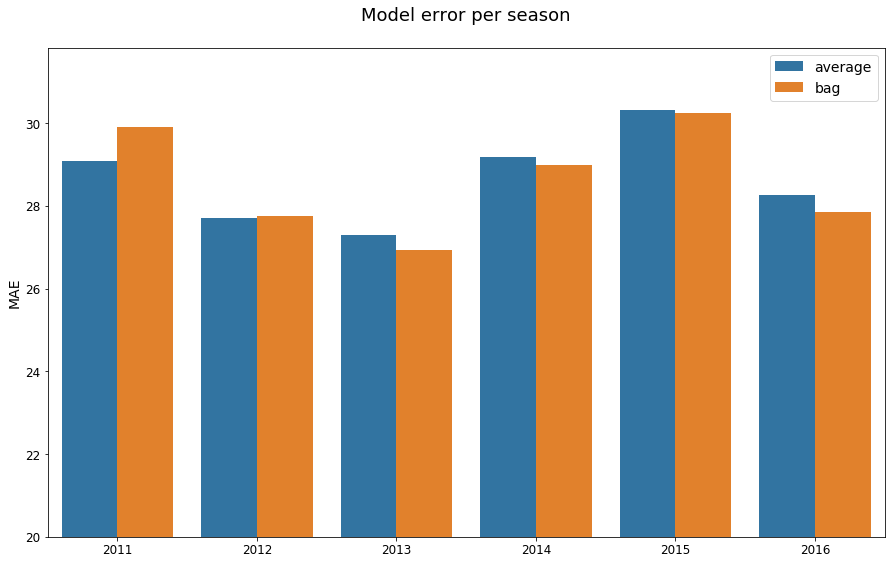

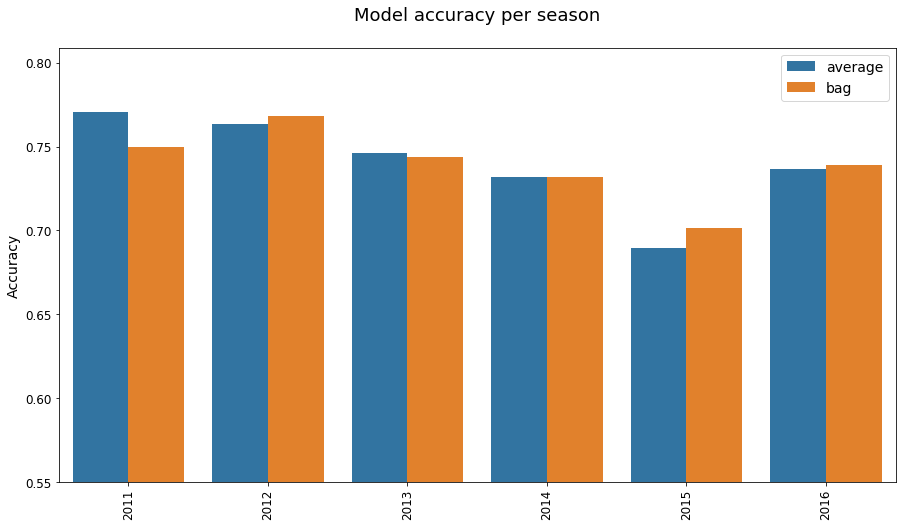

In [141]:
graph_yearly_model_performance(year_scores)

In [142]:
year_scores.groupby('model').mean()

,accuracy,error,year
model,,,
average,0.739665,28.641063,2013.5
bag,0.739091,28.617290,2013.5


### Bagging is better on a yearly basis as well
Bagging has a slightly lower error, but slightly lower accuracy. However, bagging has higher accuracy 3 out of 6 seasons, tieing averaging in a 4th.